# Heartbeat of the New York City Subway

## Data source
**MTA.info** (Turnstile data)  http://web.mta.info/developers/turnstile.html  
**Underweather**  
**Twitter**  
**Yelp** ...

## Motivation
1. The data is open, free and comprehensive.
2. "Stand on the shoulders of Giants".
2. "Smarter cities" (Turning Big Data into Insight).

In [1]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src='nycsubway.png'></td><td><img src='IBM_Smart_Cities.jpg'></td></tr></table>"))

,


<a id='table_of_contents'></a>
# Analysis Modules
1. [Pre-processing](#section1) 
 1. [Data scraping](#section1a)<a href='#section1a'></a> 
 2. [Data cleaning](#section1b)<a href='#section1b'></a> 
 3. [Live Code Session1](#section1_code) <a href='#section1_code'></a> 
2. [Exploratory analysis](#section2)
 1. [Temporal pattern](#section2a)
    1. [Q1. What are the numbers of entries/exits in a day?](#Q1) <a href='#Q1'></a>   
    2. [Q2: What are the total number of entries & exits in a week?](#Q2) <a href='#Q2'></a>  
    3. [Q3: What is the busiest time in a week?](#Q3) <a href='Q3'></a>
 2. [Spatial pattern](#section2b)
    1. [Q4: Where are people traveling to?](#Q4)<a href='Q4'></a>
3. [Categorize the station types (clustering)](#section3) <a href='#section3'></a>
 1. [Feature engineering -- Interval Passenger Entry Ratio](#section3a)<a href='#section3a'></a>
 2. [Principal component analysis](#section3b)<a href='#section3b'></a>
 3. [Clustering(K-Means)](#section3c)<a href='#section3c'></a>
4. [Predictive models](#section4)<a href='#section4'></a>
 1. [Linear regression](#section4a)<a href='#section4a'></a>
 2. [Random forest regressor](#section4b)<a href='#section4b'></a>
 3. [Time series analysis(ARIMA)](#section4c)<a href='#section4c'></a>

## 1. Pre-processing
<a id='section1a'></a>
### a. Data scraping
For data scraping, I implemented the function to automatically search and download the turnstile data from website for our interested time interval,  
e.g. ['150401','150409'].

In [2]:
import pandas as pd
import xlrd
import urllib2
import re
from datetime import datetime, timedelta

In [3]:
# Find the correct URL that contains the turnstile information of the given date
def FindURL(date):
    '''
    date: a list of one or two dates as strings, in the format of "%y%m%d"
    This function finds the right URL to pull data from. It expects a list input with length of 1 or 2. 
    For inputs of one-element list, the function will output the corresponding URL in a list;
    for inputs of two-elements list, the function will output URLs that cover the whole time range between the two dates.
    '''
    response = urllib2.urlopen('http://web.mta.info/developers/turnstile.html')
    html  = response.read()
    
    # Get all available data URLs
    availableData = re.findall(r'data\/nyct\/turnstile\/turnstile_[0-9]{6}\.txt', str(html))
    availableDataURL = ['http://web.mta.info/developers/' + x for x in availableData]
    
    # If only reading one day data
    if len(date)==1:
        date = datetime.strptime(date[0], '%y%m%d')
        week = []
        for i in range(7):
            temp_date = date + timedelta(days=i+1)
            week.append(temp_date.strftime('%y%m%d'))
        
        # Try all possible combination and match it against available URLs
        for eachDay in week:
            found = re.findall('http:\/\/web\.mta\.info\/developers\/data\/nyct\/turnstile\/turnstile_'+eachDay+'\.txt', 
                               str(availableDataURL))
            if found:
                break               
        return found
    
    # If reading data for a time period
    elif len(date)==2:
        date = [datetime.strptime(item, '%y%m%d') for item in date]
        beginDate = min(date)
        endDate = max(date) + timedelta(days=6)
        iterDate = beginDate + timedelta(days=1)
        urlList = []
        while iterDate <= (endDate + timedelta(days=1)):
            tempDate = iterDate.strftime('%y%m%d')
            found = re.findall('http:\/\/web\.mta\.info\/developers\/data\/nyct\/turnstile\/turnstile_'+ tempDate +'\.txt', 
                               str(availableDataURL))
            urlList += found
            iterDate += timedelta(days=1)
        return urlList
    
    # Raise error if input is not in the right format
    else:
        raise ValueError("Input must be a list of length one or two!")

In [4]:
# Retrieve the information from the given URL, and store it as DataFrame
def ReadSingleData(url):
    '''
    url: A string of URL
    This function returns the corresponding data of that url.
    '''
    # Get the target date
    date = re.findall('[0-9]{6}', url)[0]
    if url:
        # Data before 2014-10-11 has different structures than data afterwards
        if datetime.strptime(date, '%y%m%d') < datetime.strptime('141011', '%y%m%d'):
            column_string='C/A,UNIT,SCP,DATE1,TIME1,DESC1,ENTRIES1,EXITS1,DATE2,TIME2,DESC2,ENTRIES2,EXITS2,'+ \
            'DATE3,TIME3,DESC3,ENTRIES3,EXITS3,DATE4,TIME4,DESC4,ENTRIES4,EXITS4,DATE5,TIME5,DESC5,ENTRIES5,EXITS5,'+ \
            'DATE6,TIME6,DESC6,ENTRIES6,EXITS6,DATE7,TIME7,DESC7,ENTRIES7,EXITS7,DATE8,TIME8,DESC8,ENTRIES8,EXITS8'
            column_names=column_string.split(',')
            
            # Some NULL characters are messing the pd.read_csv function
            data=pd.read_csv(url, names=column_names, sep='\x00?,', engine='python')
            
            globalColumn1 = ['C/A', 'UNIT', 'SCP']
            globalColumn2 = ['DATE','TIME','DESC','ENTRIES','EXITS']
            
            for i in range(8):       
                colNeeded=globalColumn1 + [ x + str(i+1) for x in globalColumn2 ]
                if i==0:
                    sub_outputDF = pd.DataFrame(data[colNeeded])
                    sub_outputDF.columns=globalColumn1+globalColumn2
                else:
                    tempDF = pd.DataFrame(data[colNeeded])
                    tempDF.columns=globalColumn1+globalColumn2
                    sub_outputDF = pd.concat([sub_outputDF, tempDF], ignore_index=True)
            
            # Create TIME column for easier time subsetting
            sub_outputDF['TIME'] = sub_outputDF['DATE'] + ' ' + sub_outputDF['TIME']
            sub_outputDF['TIME'] = pd.to_datetime(sub_outputDF['TIME'], format='%m-%d-%y %H:%M:%S')
            sub_outputDF = sub_outputDF.drop('DATE', 1)
            sub_outputDF.dropna(axis=0, how='all', subset=['ENTRIES','EXITS'], inplace=True)
            
            # Merge with master file of stations
            stationMap = pd.read_excel('http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls')
            stationMap.columns = ['UNIT', 'C/A', 'STATION', 'LINENAME', 'DIVISION']
            outputDF = pd.merge(left=sub_outputDF, right=stationMap, how='left', on=['UNIT', 'C/A'], sort=False)
            orderedColumns = ['DIVISION', 'STATION', 'C/A', 'UNIT', 'SCP', 'LINENAME', 'TIME', 'DESC', 'ENTRIES', 'EXITS']
            outputDF = outputDF[orderedColumns]

        else:
            header = ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']
            outputDF=pd.read_csv(url, names=header, skiprows=1)
            
            outputDF['TIME'] = outputDF['DATE'] + ' ' + outputDF['TIME']
            outputDF['TIME'] = pd.to_datetime(outputDF['TIME'], format='%m/%d/%Y %H:%M:%S')
            outputDF = outputDF.drop('DATE', 1)
            outputDF.dropna(axis=0, how='any', inplace=True)
            orderedColumns = ['DIVISION', 'STATION', 'C/A', 'UNIT', 'SCP', 'LINENAME', 'TIME', 'DESC', 'ENTRIES', 'EXITS']
            outputDF = outputDF[orderedColumns]
    else:
        outputDF=[]
    
    return outputDF

In [5]:
def ReadData(date):
    '''
    date: a list of one or two dates as strings, in the format of "%y%m%d"
    This function returns the corresponding data of inputs. It expects a list input with length of 1 or 2. 
    For inputs of one-element list, the function will output data of that single day;
    for inputs of two-elements list, the function will output data of the time periods between the two days.
    '''
    if len(date) < 3:
        urlList = FindURL(date)
        data = pd.DataFrame()
        for url in urlList:
            temp = ReadSingleData(url)
            data = data.append(temp)
    else:
        raise ValueError("Input must be a list of length one or two!")
    
    date = [datetime.strptime(item, '%y%m%d') for item in date]
    beginDate = min(date)
    endDate = max(date) + timedelta(days=1)
    
    # Subset to desired time range
    output = data[(data['TIME'] >= beginDate) & (data['TIME'] <= endDate)]
    output.reset_index(drop=True, inplace=True)
    
    # Sort data frame for future calculation of interval entry
    output.sort_values(['DIVISION', 'STATION', 'C/A', 'UNIT', 'SCP', 'TIME'], inplace=True)
    output.reset_index(drop=True, inplace=True)
    
    return output

<a id='section1b'></a>
### b. Data cleaning 
 * Calculate the entry/exit number of passengers between time intervals
 * Remove all the negative entry/exit numbers
 * Remove the unrealistic extreme large values using 99% quantile

In [6]:
def DataClean(data):
    # Make sure data is sorted accordingly
    data.sort_values(['DIVISION','STATION', 'C/A', 'UNIT', 'SCP', 'TIME'], inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    # Calculate interval entries and exits
    intervalEntry = data.groupby(['C/A', 'UNIT', 'SCP'])['ENTRIES'].transform(lambda x: x-x.shift()).fillna(0)
    intervalExit = data.groupby(['C/A', 'UNIT', 'SCP'])['EXITS'].transform(lambda x: x-x.shift()).fillna(0)
    
    # Get rid of negative values
    intervalEntry[intervalEntry<0] = 0
    intervalExit[intervalExit<0] = 0
    
    # Capping interval entries and exits using 99% quantile
    capEntry = intervalEntry.quantile(0.99)
    capExit = intervalExit.quantile(0.99)
    intervalEntry[intervalEntry>capEntry] = 0
    intervalExit[intervalExit>capExit] = 0

    # Add columns to data
    data['intvlEntry'] = pd.Series(intervalEntry, index = data.index)
    data['intvlExit'] = pd.Series(intervalExit, index = data.index)
    
    # Drop the previous "Entry" and "Exit" columns
    data.drop(['ENTRIES','EXITS'],axis = 1,inplace= True)
    
    return data

[Back to top](#table_of_contents)
<a href='#table_of_contents'></a>

<a id='section1_code'></a>
**Live Code Session 1 -- Data scraping and cleaning**  
  * **FindURL(dates)**: Find the correct url for the dates in interest
  * **ReadSingleData(url)**: Read the information from given url, and store it in DataFrame  
  * **ReadData(dates)**: FindURL + ReadSingleData (applied for multiple urls)
  * **DataClean(data)**: Pre-process and clean the dataframe

In [7]:
dates = ['150601','150630']
sub_data = ReadData(dates)
sub_data = DataClean(sub_data)

# fname_csv = 'NYCT' + '_'.join(dates) + '.csv'
# sub_data.to_csv(fname_csv)

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
sub_data.head()

,DIVISION,STATION,C/A,UNIT,SCP,LINENAME,TIME,DESC,intvlEntry,intvlExit
0,BMT,1 AVE,H007,R248,00-00-00,L,2015-06-01 00:00:00,REGULAR,0.0,0.0
1,BMT,1 AVE,H007,R248,00-00-00,L,2015-06-01 04:00:00,REGULAR,37.0,64.0
2,BMT,1 AVE,H007,R248,00-00-00,L,2015-06-01 08:00:00,REGULAR,321.0,785.0
3,BMT,1 AVE,H007,R248,00-00-00,L,2015-06-01 12:00:00,REGULAR,0.0,0.0
4,BMT,1 AVE,H007,R248,00-00-00,L,2015-06-01 16:00:00,REGULAR,1008.0,731.0


[Back to top](#table_of_contents)
<a href='#table_of_contents'></a>

## 2. Exploratory analysis

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [10]:
def Parse_Time(data):
    
    data['TIME'] = pd.to_datetime(data['TIME'],format='%Y/%m/%d %H:%M:%S')
    data['Month'] = pd.Series([x.date().month for x in data['TIME']])
    data['Day'] = pd.Series([x.date().day for x in data['TIME']])
    data['Hour'] = pd.Series([x.time().hour for x in data['TIME']])
    data['Weekday'] = pd.Series([x.date().weekday() for x in data['TIME']])
    
    Weekday_dict = { 0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thur', 4: 'Fri', 5:'Sat', 6:'Sun'}
    Month_dict = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5:'May', 6:'Jun', 7: 'Jul', 8: 'Aug', 9:'Sep', 10:'Oct', 11:'Nov',12: 'Dec'}
    data['Weekday'] = data['Weekday'].map(Weekday_dict)
    data['Month'] = data['Month'].map(Month_dict)    
    
    return data

In [11]:
#sub_data = pd.read_csv(fname_csv)
#sub_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
sub_data = Parse_Time(sub_data)

### a. Temporal pattern

<a id='Q1'></a>
### Q1: How are numbers of entries/exits changing daily for a subway station?

In [68]:
def Visualize_Station_hist(sub_data, station_name, time_period):
    
    temp = sub_data[sub_data.STATION == station_name]
    station_data = temp[(temp.TIME > time_period[0])&(temp.TIME < time_period[1])]
    station_data.sort_values(['TIME'], inplace = True)
    
    station_entry_exit_hist = station_data.groupby('TIME')['intvlEntry','intvlExit'].sum()
    station_entry_exit_hist.plot(figsize = (12,6),linestyle='--',marker='o')
    plt.ylim([0,1.5*station_entry_exit_hist.max().max()])
    
    plt.savefig('Ridership_Time.png')
    
    return station_entry_exit_hist

**Live code session:**

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


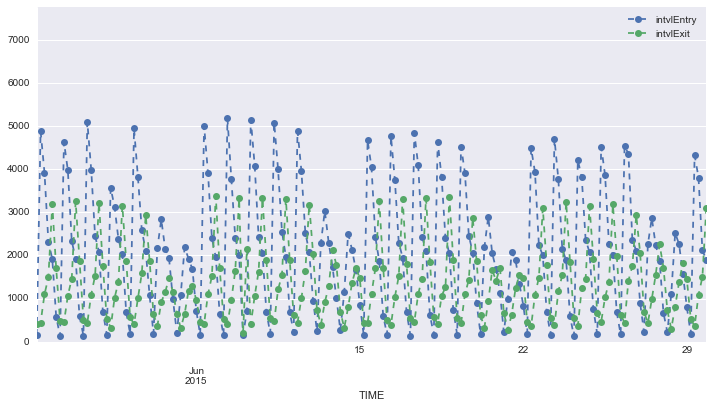

In [69]:
## Candidate stations: '14 ST-UNION SQ', '104 ST', '111 ST', '121 ST' ...

station_entry_exit_hist = Visualize_Station_hist(sub_data,  '111 ST',[datetime(2015,6,1),datetime(2015,6,30)])

[Back to top](#table_of_contents)
<a href='#table_of_contents'></a>

<a id='Q2'></a>
### Q2: What are the total number of entries & exits across the city everyday ?

In [14]:
weekday_entry = sub_data.groupby(['Weekday','Day'])['intvlEntry'].sum()
weekday_entry_ave = weekday_entry.unstack().mean(axis = 1).reindex(['Mon','Tue','Wed','Thur','Fri', 'Sat','Sun'])
weekday_exit = sub_data.groupby(['Weekday','Day'])['intvlExit'].sum()
weekday_exit_ave = weekday_exit.unstack().mean(axis = 1).reindex(['Mon','Tue','Wed','Thur','Fri', 'Sat','Sun'])

entry_exit_ave = pd.concat([weekday_entry_ave, weekday_exit_ave],axis = 1)
entry_exit_ave = entry_exit_ave/1000
entry_exit_ave.columns = ['Entry', 'Exit']

In [15]:
#weekday_entry

**Live code session:**

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

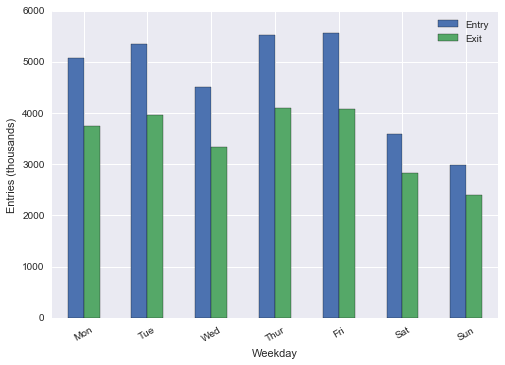

In [16]:
entry_exit_ave.plot(kind = 'bar')
plt.ylabel('Entries (thousands)')
plt.xticks(rotation=30)

[Back to top](#table_of_contents)
<a href='#table_of_contents'></a>


### Q3: What is the busiest time of a week?

In [17]:
# Create features "Busyness" and "Net_flow_in"
sub_data['Busyness'] = sub_data['intvlExit'] + sub_data['intvlEntry']
sub_data['Net_flow_in'] = sub_data['intvlEntry']-sub_data['intvlExit']

In [18]:
# Further format the data into six time groups
def group_time(x):
    if x>=0 and x<4:
        return '0 - 4'
    elif x < 8:
        return '4 - 8'
    elif x < 12:
        return '8 - 12'
    elif x < 16:
        return '12 - 16'
    elif x < 20:
        return '16 - 20'
    elif x < 24:
        return '20 - 24'
    
sub_data['time_group'] = sub_data['Hour'].apply(group_time)

In [19]:
sub_weekly = sub_data.groupby(['time_group','Weekday'])['Busyness','Net_flow_in'].mean().reindex(['Mon','Tue','Wed','Thur','Fri','Sat','Sun'],level = 1)
sub_weekly.reindex(['0 - 4', '4 - 8','8 - 12', '12 - 16','16 - 20', '20 - 24'],level = 0).unstack()
sub_weekly_busyness = sub_weekly['Busyness'].unstack().reindex(['0 - 4', '4 - 8','8 - 12', '12 - 16','16 - 20', '20 - 24'])
sub_weekly_busyness = sub_weekly_busyness.astype(int)

sub_weekly_netflow = sub_weekly['Net_flow_in'].unstack().reindex(['0 - 4', '4 - 8','8 - 12', '12 - 16','16 - 20', '20 - 24'])
sub_weekly_netflow = sub_weekly_netflow.astype(int)

<a id='Q3'></a>
**Live code session:**

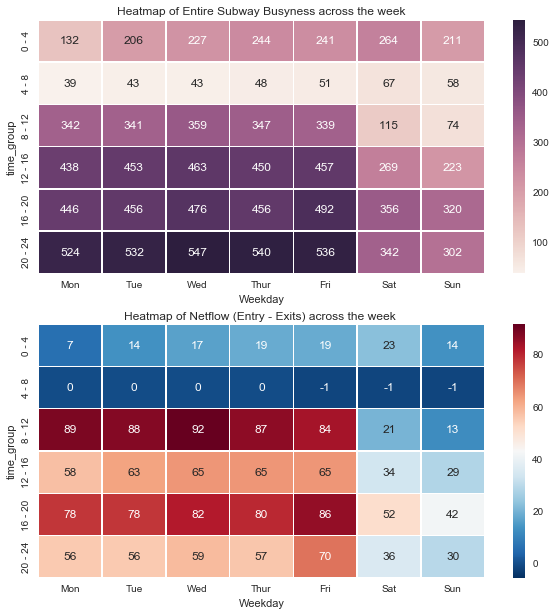

In [72]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
sns.heatmap(sub_weekly_busyness,annot = True, fmt="d", linewidths=.5, cbar = True, ax=ax1)
ax1.set_title('Heatmap of Entire Subway Busyness across the week')

sns.heatmap(sub_weekly_netflow,annot = True, fmt="d", linewidths=.5, cbar = True, center =sub_weekly_netflow.mean().mean(),ax=ax2)
ax2.set_title('Heatmap of Netflow (Entry - Exits) across the week ')
#plt.show()
plt.savefig('Heatmap.png')

[Back to top](#table_of_contents)
<a href='#table_of_contents'></a>


### Q4: How are passengers moving across the city?

In [22]:
nyc_station_location = pd.read_csv('turnstile_weather_v2.csv')
nyc_station_longlat = nyc_station_location [['station', 'latitude','longitude']].groupby(['station'])['latitude','longitude'].mean()

In [23]:
def prepare_plot_data(day, time_group):
    
    if (day in ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']):
        sub_day_data = sub_data[sub_data['Weekday']== day]
    else:
        sub_day_data = sub_data[sub_data['Day']== int(day)]
        
    station_netflow = sub_day_data.groupby(['STATION', 'time_group'])['Net_flow_in'].mean()
    station_netflow.reindex(['0 - 4', '4 - 8', '8 - 12', '12 - 16', '16 - 20', '20 - 24'], level=1)
    
    station_busyness = sub_day_data.groupby(['STATION', 'time_group'])['Busyness'].mean()
    station_busyness.reindex(['0 - 4', '4 - 8', '8 - 12', '12 - 16', '16 - 20', '20 - 24'], level=1)
    
    station_netflow = station_netflow.unstack()
    station_busyness = station_busyness.unstack()
    
    station_netflow = station_netflow.merge(nyc_station_longlat,left_index = True, right_index = True)
    station_busyness = station_busyness.merge(nyc_station_longlat,left_index = True, right_index = True)
    
    busyness_data = station_busyness[['latitude', 'longitude', time_group]]
    netflow_data = station_netflow[[time_group]]
    plot_data = busyness_data.merge(netflow_data, left_index=True, right_index=True)
    x_column_name = time_group+'_x'
    y_column_name = time_group+'_y'
    plot_data = plot_data.rename(columns = {x_column_name: 'busyness', y_column_name: 'netflow'})
    return plot_data

In [24]:
def transform_coordinates(series, old_origin, old_width, new_origin, new_width):
    old_origin = float(old_origin)
    old_width = float(old_width)
    new_origin = float(new_origin)
    new_width = float(new_width)
    return new_origin + (series - old_origin) / old_width * new_width

In [25]:
import matplotlib.lines as lines
day_dict={'Mon': "Monday", 'Tue': 'Tuesday', 'Wed': "Wednesday", 'Thu': 'Thursday', 
          'Fri':'Friday', 'Sat':'Saturday','Sun':'Sunday'}
# time_group_dict = {'0 - 4':'0:00-4:00','4 - 8':'4:00-8:00','8 - 12':'8:00 - 12:00',
#                    '12 - 16':'12:00-16:00','16 - 20':'16:00-20:00','20 - 24':'20:00-24:00'}
def spatial_plot(day, time_group): 
    img = plt.imread('new-york.png')
    strlist = time_group.split(' ')
    if (day in ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']):
        title = "NYC Subway Passenger Flow on " + day_dict[day] + ' during ' + strlist[0] +':00' + '-' + strlist[2] +':00'
    else:
        title = "NYC Subway Passenger Flow on  Day " + day + ' during ' + strlist[0] +':00' + '-' + strlist[2] +':00'
    ypixels, xpixels, bands = img.shape
    dpi = 72.
    xinch = xpixels / dpi
    yinch = ypixels / dpi
    fig = plt.figure(figsize=(xinch/2.0, yinch * 0.5/ .85))
    plot_data = prepare_plot_data(day, time_group)
    xpos = transform_coordinates(plot_data['longitude'], -74.1, .35, 0, xpixels)
    ypos = transform_coordinates(plot_data['latitude'], 40.55, .35, ypixels, -ypixels)

    plt.axes([0., 0., 1., .9], frameon=False, xticks=[], yticks=[])
    # plot background image with map
    plt.imshow(img, interpolation='none')
    plt.scatter(x = xpos, y = ypos, c=plot_data['netflow'], s=plot_data['busyness']/8,
                cmap = 'seismic', linewidths= 0, alpha=0.7)
    plt.xlim(0, xpixels)
    plt.ylim(ypixels, 0)
    fig.suptitle(title, fontsize=16)
    dot1 = lines.Line2D([0], [0], c='white', marker='o', mfc='gray', ms=4, mew=0)
    dot2 = lines.Line2D([0], [0], c='white', marker='o', mfc='gray', ms=8, mew=0)
    dot3 = lines.Line2D([0], [0], c='white', marker='o', mfc='red', ms=6, mew=0)
    dot4 = lines.Line2D([0], [0], c='white', marker='o', mfc='blue', ms=6, mew=0)
    legend = plt.legend([dot1, dot2, dot3, dot4],
            ['Stations with less passengers',
             'Stations with more passengers',
             'Stations with more people entering',
             'Stations with more people exiting'],  bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0., fontsize=9)

    return plt

<a id='Q4'></a>
**Live code session:**

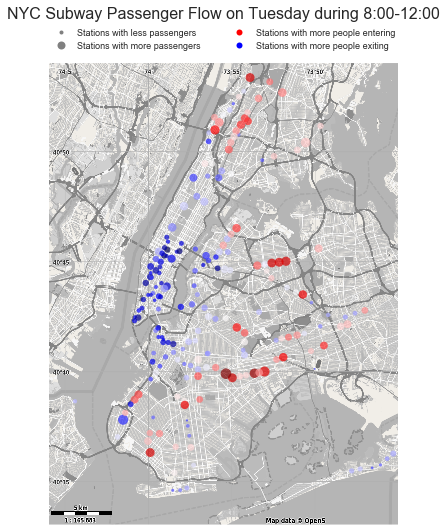

In [73]:
## run Parse_time
plt=spatial_plot('Tue','8 - 12')
plt.savefig('Weekday_morning.png')

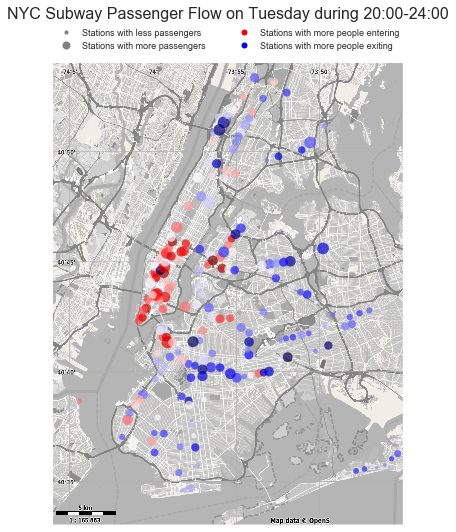

In [79]:
plt=spatial_plot('Tue','20 - 24')
plt.savefig('Weekday_night.png')

In [29]:
# fname_csv2 = 'NYCT' + '_'.join(dates) + 'v2.csv'
# sub_data.to_csv(fname_csv2)

[Back to top](#table_of_contents)
<a href='#table_of_contents'></a>

<a id='section3'></a>
## 3. Categorize the station types 

In [30]:
# sub_data = pd.read_csv(fname_csv2)
# sub_data.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [31]:
def is_weekday(x):
    if x in ['Mon', 'Tue', 'Wed', 'Thur', 'Fri']:
        return True
    return False

<a id='section3a'></a>
### a. Feature engineering -- Interval entry ratio

In [32]:
# Clustering based on intvlEntry
cluster_var = 'intvlEntry'

In [33]:
station_weekdays = sub_data[sub_data['Weekday'].apply(is_weekday)].groupby(['STATION','Weekday','time_group','Day'])[cluster_var].sum().unstack(level=-2)
station_weekdays_ave = station_weekdays.groupby([station_weekdays.index.get_level_values(0),station_weekdays.index.get_level_values(1)]).mean()
station_weekdays_ave = station_weekdays_ave.reindex(['Mon','Tue','Wed','Thur','Fri'], level = 1)
station_weekdays_ave = station_weekdays_ave.ix[:, ['0 - 4', '4 - 8', '8 - 12', '12 - 16', '16 - 20', '20 - 24']]

station_weekday_hourly = station_weekdays_ave.groupby(level=0).mean()
station_weekday_hourly_norm = station_weekday_hourly.apply(lambda x: x/sum(x), axis = 1)

In [34]:
station_weekends = sub_data[~sub_data['Weekday'].apply(is_weekday)].groupby(['STATION','Weekday','time_group','Day'])[cluster_var].sum().unstack(level=-2)
station_weekends_ave = station_weekends.groupby([station_weekends.index.get_level_values(0),station_weekends.index.get_level_values(1)]).mean()
station_weekends_ave = station_weekends_ave.ix[:, ['0 - 4', '4 - 8', '8 - 12', '12 - 16', '16 - 20', '20 - 24']]

station_weekend_hourly = station_weekends_ave.groupby(level=0).mean()
station_weekend_hourly_norm = station_weekend_hourly.apply(lambda x: x/sum(x), axis = 1)

In [35]:
station_weekly_norm = station_weekday_hourly_norm.merge(station_weekend_hourly_norm, left_index = True, right_index = True)
station_weekly_norm.dropna(axis=0, how='any', inplace=True)

**Live code session:**

In [36]:
# station_weekday_hourly_norm.head()
# station_weekend_hourly_norm.head()
# station_weekly_norm.head()

<a id='section3b'></a>
### b. Principal component analysis

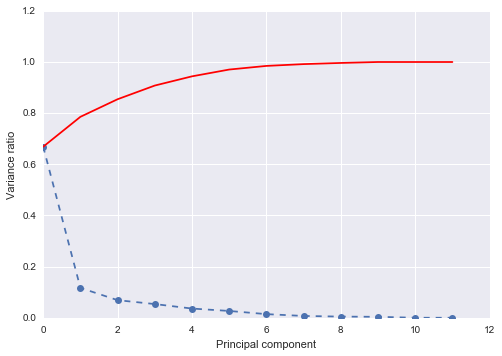

In [37]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(station_weekly_norm)

plt.plot(pca.explained_variance_ratio_,'o--')
plt.plot(np.cumsum(pca.explained_variance_ratio_),'r-')
plt.xlabel('Principal component')
plt.ylabel('Variance ratio')

In [38]:
station_weekly_norm_pca = pca.transform(station_weekly_norm)
station_weekly_norm_pca = pd.DataFrame(station_weekly_norm_pca[:,0:5], index = station_weekly_norm.index)
# station_weekly_norm_pca.head()


### c. Clustering (K-Means)

In [81]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4).fit(station_weekly_norm_pca)
station_type = pd.DataFrame(kmeans.labels_,index = station_weekly_norm_pca.index)

In [82]:
station_type = station_type.merge(nyc_station_longlat,left_index = True, right_index = True)
station_type.columns = ['Cluster','latitude','longitude']

<a id='section3c'></a>
### Clustering

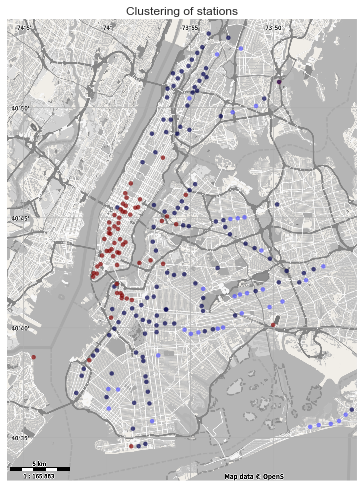

In [84]:
img = plt.imread('new-york.png')
ypixels, xpixels, bands = img.shape
dpi = 72.
xinch = xpixels / dpi
yinch = ypixels / dpi
fig = plt.figure(figsize=(xinch/2.0, yinch * 0.5/ .85))
xpos = transform_coordinates(station_type['longitude'], -74.1, .35, 0, xpixels)
ypos = transform_coordinates(station_type['latitude'], 40.55, .35, ypixels, -ypixels)

plt.axes([0., 0., 1., .9], frameon=False, xticks=[], yticks=[])
# plot background image with map
plt.imshow(img, interpolation='none')
plt.scatter(x = xpos, y = ypos, c=station_type['Cluster'],
            cmap = 'seismic', linewidths= 0, alpha=0.7)
plt.xlim(0, xpixels)
plt.ylim(ypixels, 0)
plt.title('Clustering of stations')
#plt.colorbar()
plt.savefig('cluster.png')

In [42]:
station_weekly_norm = station_weekly_norm.merge(station_type,left_index = True, right_index = True)
# station_weekly_norm.head()

In [43]:
# station_type.Cluster.value_counts()

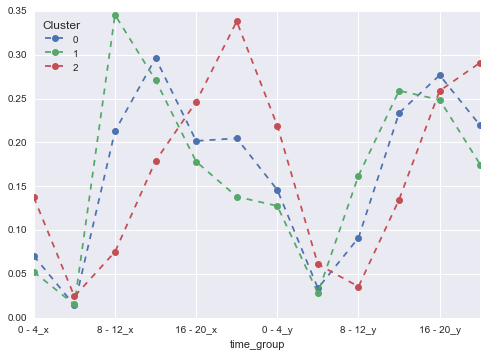

In [92]:
station_weekly_cluster_trend = station_weekly_norm.groupby(['Cluster']).mean()
station_weekly_cluster_trend.drop(['latitude', 'longitude'], axis = 1, inplace = True)
station_weekly_cluster_trend.transpose().drop(3,axis=1).plot(marker = 'o', linestyle = '--')
#plt.ylim(0,0.8)
plt.savefig('Cluster_trend.png')

In [90]:
station_weekly_cluster_trend.transpose().drop(3,axis=1)

Cluster,0,1,2
time_group,,,
0 - 4_x,0.070518,0.052211,0.137301
4 - 8_x,0.014145,0.015152,0.024357
8 - 12_x,0.212935,0.345430,0.075206
12 - 16_x,0.296104,0.270988,0.178893
16 - 20_x,0.201648,0.178106,0.246278
20 - 24_x,0.204649,0.138114,0.337964
0 - 4_y,0.145813,0.127546,0.218998
4 - 8_y,0.033616,0.028224,0.061021
8 - 12_y,0.091174,0.162044,0.035518


In [45]:
# station_weekly_cluster_trend

In [46]:
# cluster_csv = 'NYCT' + '_'.join(dates) + 'cluster4.csv'
# station_type.to_csv(cluster_csv)

[Back to top](#table_of_contents)
<a href='#table_of_contents'></a>

<a id='section4'></a>
## 4. Predictive models
Since there are repeated patterns for the ridership, we can try to build a prediction model to predict the possible number of entry passengers for a given station in future.  
Provided features : station type, time of the day, weekday.

In [47]:
# sub_data = pd.read_csv('fname_csv2')
# sub_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
# sub_data = Parse_Time(sub_data)
# station_cluster = pd.read_csv(cluster_csv)
# station_cluster.drop(['latitude','longitude'], axis = 1, inplace = True)

In [48]:
station_cluster = station_type
station_cluster.drop(['latitude','longitude'], axis = 1, inplace = True)
station_cluster.reset_index(inplace = True)
station_cluster.columns = ['STATION', 'Cluster']

In [49]:
sub_data = sub_data.merge(station_cluster,left_on = 'STATION', right_on = 'STATION')

In [50]:
f = {'intvlEntry':['sum'], 'intvlExit':['sum'], 'Cluster':['mean']}
sub_data_cluster = sub_data.groupby(['STATION','TIME']).agg(f)    
sub_data_cluster.reset_index(level=['STATION', 'TIME'], inplace = True)
sub_data_cluster.columns = sub_data_cluster.columns.get_level_values(0)
# sub_data_cluster.head()

In [51]:
Weekday_dict = { 0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thur', 4: 'Fri', 5:'Sat', 6:'Sun'}
sub_data_cluster['Weekday'] = pd.Series([x.date().weekday() for x in sub_data_cluster['TIME']])
sub_data_cluster['Weekday'] = sub_data_cluster['Weekday'].map(Weekday_dict)

sub_data_cluster['Day'] = pd.Series([x.date().day for x in sub_data_cluster['TIME']])
sub_data_cluster['Hour'] = pd.Series([x.time().hour for x in sub_data_cluster['TIME']])
sub_data_cluster['time_group'] = sub_data_cluster['Hour'].apply(group_time)

#sub_data_cluster.head()

In [52]:
model_data = sub_data_cluster[['STATION','Day','Weekday','time_group','Cluster','intvlEntry']]
# model_data.head()

In [53]:
cluster_dummies  = pd.get_dummies(model_data['Cluster'])
model_data = pd.concat([model_data,cluster_dummies],axis=1)

time_group_dummies  = pd.get_dummies(model_data['time_group'])
model_data = pd.concat([model_data,time_group_dummies],axis=1)

weekday_dummies  = pd.get_dummies(model_data['Weekday'])
model_data = pd.concat([model_data,weekday_dummies],axis=1)

model_data.drop(['Weekday','time_group','Cluster',3,'0 - 4','Mon'], axis=1,inplace=True)
# model_data.head()

** Training and Testing Dataset**

In [93]:
train = model_data[model_data.Day <= 25]
test = model_data[model_data.Day > 25]
test_full = sub_data_cluster[sub_data_cluster.Day > 25]

test_predict = pd.Series(index=test.index)

In [55]:
#train.head()

<a id='section4a'></a>
### a. Linear regression

In [94]:
from sklearn.linear_model import LinearRegression

for station in test.STATION.unique():

    features_train = train[train.STATION == station].drop(['STATION','Day','intvlEntry'], axis = 1)
    target_train = train[train.STATION == station]['intvlEntry']

    features_test = test[test.STATION == station].drop(['STATION','Day','intvlEntry'], axis = 1)
    target_test = test[test.STATION == station]['intvlEntry']

    reg = LinearRegression()
    reg.fit(features_train, target_train)

    predict_station = pd.Series(reg.predict(features_test), index = target_test.index)
    
    test_predict.loc[predict_station.index] = reg.predict(features_test)
    
test_full['Linear'] = test_predict 

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


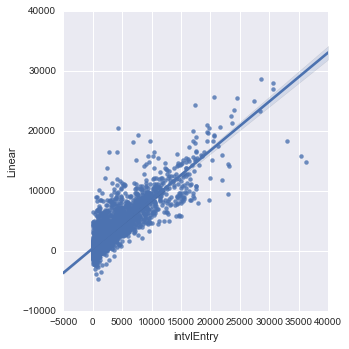

In [96]:
sns_lmplot=sns.lmplot(x='intvlEntry', y='Linear',data = test_full)
sns_lmplot.savefig('Linear_regression.png')

In [58]:
from sklearn.metrics import r2_score
print r2_score(test_full['intvlEntry'], test_full['pred'])

0.785857434917


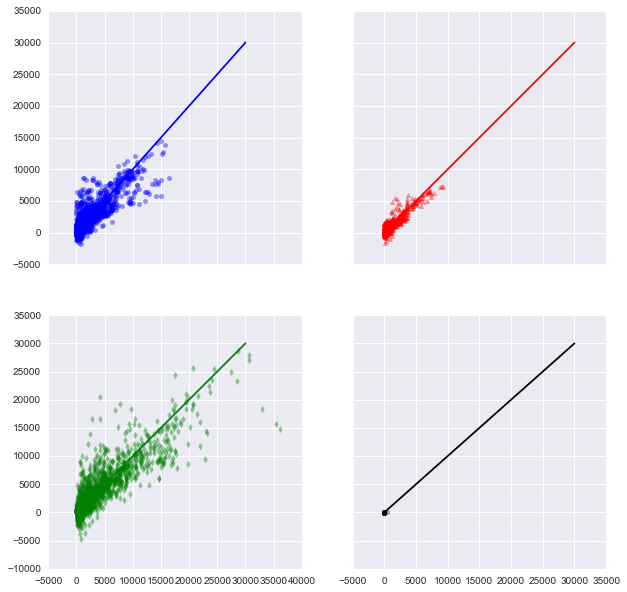

In [59]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10),sharex='col', sharey='row')
ax1.scatter(test_full[test_full.Cluster == 0]['intvlEntry'], test_full[test_full.Cluster == 0]['pred'], color = 'b', alpha = 0.4)
ax1.plot([0,30000],[0,30000], color = 'b')
ax2.scatter(test_full[test_full.Cluster == 1]['intvlEntry'], test_full[test_full.Cluster == 1]['pred'], color = 'r',marker='^', alpha=.4)
ax2.plot([0,30000],[0,30000], color = 'r')
ax3.scatter(test_full[test_full.Cluster == 2]['intvlEntry'], test_full[test_full.Cluster == 2]['pred'], color = 'g',marker='d', alpha=.4)
ax3.plot([0,30000],[0,30000], color = 'g')
ax4.scatter(test_full[test_full.Cluster == 3]['intvlEntry'], test_full[test_full.Cluster == 3]['pred'], color = 'k', alpha=.4)
ax4.plot([0,30000],[0,30000], color = 'k')

<a id='section4b'></a>
### b. RandomForest Regressor

In [60]:
from sklearn.ensemble import RandomForestRegressor

In [97]:
for station in test.STATION.unique():

    features_train = train[train.STATION == station].drop(['STATION','Day','intvlEntry'], axis = 1)
    target_train = train[train.STATION == station]['intvlEntry']

    features_test = test[test.STATION == station].drop(['STATION','Day','intvlEntry'], axis = 1)
    target_test = test[test.STATION == station]['intvlEntry']

    reg = RandomForestRegressor()
    reg.fit(features_train, target_train)   
    
    predict_station = pd.Series(reg.predict(features_test), index = target_test.index)
    
    test_predict.loc[predict_station.index] = reg.predict(features_test)
    
test_full['Random'] = test_predict 

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


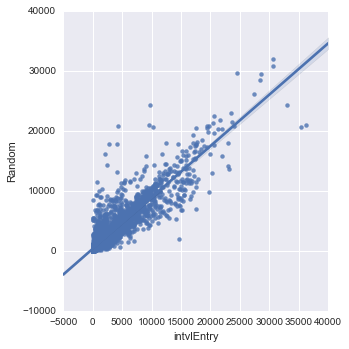

In [98]:
sns.lmplot(x='intvlEntry', y='Random',data = test_full)
sns_lmplot.savefig('Random_regression.png')

In [63]:
from sklearn.metrics import r2_score
print r2_score(test['intvlEntry'], test_full['pred2'])

0.837675100984


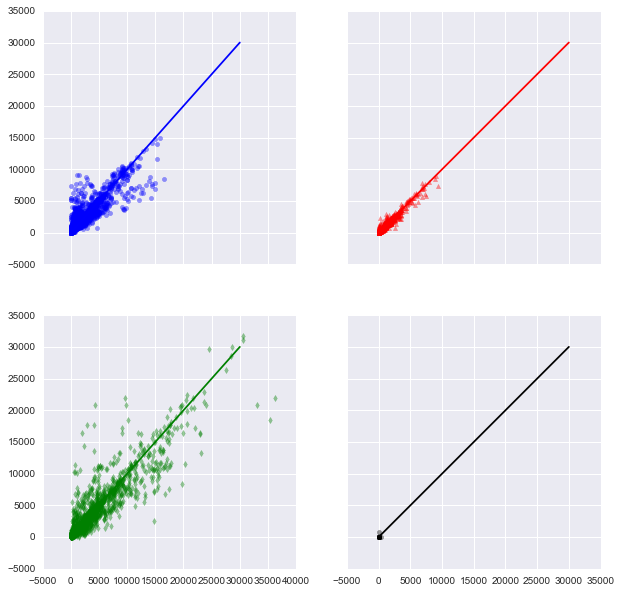

In [64]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10),sharex='col', sharey='row')
ax1.scatter(test_full[test_full.Cluster == 0]['intvlEntry'], test_full[test_full.Cluster == 0]['pred2'], color = 'b', alpha = 0.4)
ax1.plot([0,30000],[0,30000], color = 'b')
ax2.scatter(test_full[test_full.Cluster == 1]['intvlEntry'], test_full[test_full.Cluster == 1]['pred2'], color = 'r',marker='^', alpha=.4)
ax2.plot([0,30000],[0,30000], color = 'r')
ax3.scatter(test_full[test_full.Cluster == 2]['intvlEntry'], test_full[test_full.Cluster == 2]['pred2'], color = 'g',marker='d', alpha=.4)
ax3.plot([0,30000],[0,30000], color = 'g')
ax4.scatter(test_full[test_full.Cluster == 3]['intvlEntry'], test_full[test_full.Cluster == 3]['pred2'], color = 'k', alpha=.4)
ax4.plot([0,30000],[0,30000], color = 'k')

**Visualize the prediction for a given subway station**

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


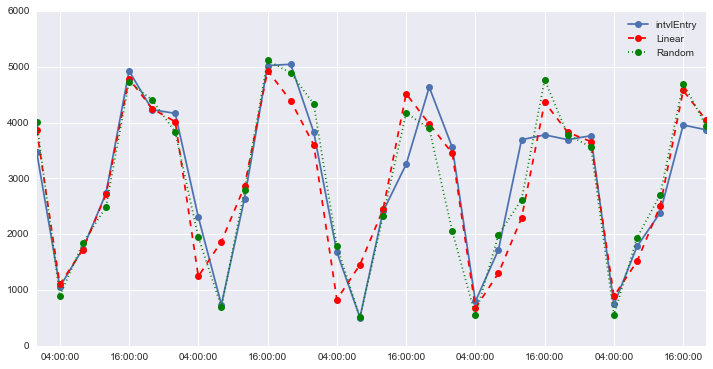

In [101]:
station_name = '1 AVE'

test_full.sort_values(['STATION','TIME'], inplace=True)
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(test_full[test_full.STATION == station_name]['TIME'],test_full[test_full.STATION == station_name]['intvlEntry'],'o-')
ax.plot(test_full[test_full.STATION == station_name]['TIME'],test_full[test_full.STATION == station_name]['Linear'],'ro--')
ax.plot(test_full[test_full.STATION == station_name]['TIME'],test_full[test_full.STATION == station_name]['Random'],'go:')
ax.legend()
plt.savefig('ridership_prediction.png')

<a id='section4c'></a>
### c. Time Series (ARIMA)

In [ ]:
import statsmodels as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
# sub_data = pd.read_csv(fname_csv2)
# sub_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
# sub_data = Parse_Time(sub_data)

In [ ]:
entry_all_ts = sub_data.groupby(['STATION','TIME'])['intvlEntry'].sum()

Station = '1 AVE'
station_entry_ts = entry_all_ts[Station]

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=6)
    rolstd = pd.rolling_std(timeseries, window=6)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(10, 8))
    orig = plt.plot(timeseries, color='blue',label='Original', marker = 'o', linestyle ='--')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    
#test_stationarity(station_entry_ts)

In [ ]:
decomposition = seasonal_decompose(station_entry_ts,freq = 6)  
# fig = plt.figure()  
# fig = decomposition.plot()  
# fig.set_size_inches(10, 6)

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(station_entry_ts, nlags=20)
lag_pacf = pacf(station_entry_ts, nlags=20, method='ols')

# #Plot ACF: 
# fig, (ax1, ax2) = plt.subplots(1,2)
# ax1.plot(lag_acf,'o-')
# ax1.axhline(y=0,linestyle='--',color='gray')
# ax1.axhline(y=-1.96/np.sqrt(len(station_entry_ts)),linestyle='--',color='gray')
# ax1.axhline(y=1.96/np.sqrt(len(station_entry_ts)),linestyle='--',color='gray')
# plt.title('Autocorrelation Function')

# ax2.plot(lag_pacf,'o-')
# ax2.axhline(y=0,linestyle='--',color='gray')
# ax2.axhline(y=-1.96/np.sqrt(len(station_entry_ts)),linestyle='--',color='gray')
# ax2.axhline(y=1.96/np.sqrt(len(station_entry_ts)),linestyle='--',color='gray')
# plt.title('Partial Autocorrelation Function')
# plt.tight_layout()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# p = 2, q = 2

model = ARIMA(station_entry_ts, order=(2, 0, 2))  
results_ARIMA = model.fit(disp=-1) 
predict_ARIMA = results_ARIMA.fittedvalues

fig = plt.figure(figsize=(10, 6))
plt.plot(station_entry_ts,'o-')
plt.plot(results_ARIMA.fittedvalues,'ro--')